In [1]:
import pickle
import shutil
import csv
import os
import librosa
import librosa.display
import pyaudio
import wave
import keras
import pyaudio  
import sys
import numpy as np
import matplotlib.pyplot as plt
import speech_recognition as speech_r
import scipy.signal as signal
import random as rn
import tensorflow as tf
import pandas as pd
from pydub import AudioSegment
from time import sleep
from matplotlib import cm
from python_speech_features import logfbank, fbank
from scipy.fftpack import dct
from silence_remover.silence_detector import SilenceDetector
from silence_remover.filter_generator import FilterGenerator
from silence_remover.media_editor import MediaEditor
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
from sklearn.linear_model import LogisticRegression
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.layers import Dense,concatenate, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, MaxPooling1D,Multiply,Conv1D, Conv2D, MaxPooling2D
from playsound import playsound
from sklearn.model_selection import train_test_split

C:\Users\thakd\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\thakd\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\thakd\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\thakd\anaconda3\envs\test\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [15]:
DATA_PATH = "./train_mfcc/"
X_train = [] 
X_test = []
Y_train = []
Y_test = []
tf_classes = 0
labels = []
X_data = []
Y_label = []

    
def load_npy(save_path) : 
    
    # 데이터들을 저장할 배열
    
    global X_train, X_test, Y_train, Y_test, tf_classes
    
    folders = os.listdir(save_path) ## 경로에 있는 폭더 목록
    
    for folder in folders :
        
        if not os.path.isdir(save_path) : continue 
            
        files = os.listdir(save_path + "/" + folder)        
        print("Foldername : ", folder, "-", len(files),"파일")
        
        for file in files:
            if not file.endswith(".npy") : continue ## 미리 전처리하여 변환한 npy불러오기
            
            else:               
                mfcc = np.load(save_path + "/" + folder + "/" + file) ## mfcc변환한 파일 값 저장
                X_data.extend(mfcc)
                
                label = [0 for i in range(len(folders))]
                label[tf_classes] = 1 ## 폴더 순서대로 라벨링
        
                for i in range(len(mfcc)) :
                    Y_label.append(label)
                    
        tf_classes = tf_classes + 1 ## 클래스번호 부여

    print("X_data : ", np.shape(X_data))
    print("Y_label : ", np.shape(Y_label))
    X_train, X_test, Y_train, Y_test = train_test_split(np.array(X_data), np.array(Y_label), test_size = 0.2, stratify = np.array(Y_label))
    xy = (X_train, X_test, Y_train, Y_test)

In [16]:
load_npy(DATA_PATH)

print(tf_classes,"개의 클래스!!")
print("X_train : ", np.shape(X_train))
print("Y_train : ", np.shape(Y_train))
print("X_test : ", np.shape(X_test))
print("Y_test : ", np.shape(Y_test))

X_train = np.expand_dims(X_train, -1) # 차수 늘리기 >> Conv1D는 3개의 텐서가 필요 
X_test = np.expand_dims(X_test, -1)
print(X_train.shape)
print(X_test.shape)

Foldername :  강은기 - 20 파일
Foldername :  강은서 - 20 파일
Foldername :  김나리 - 20 파일
Foldername :  김엄지 - 20 파일
Foldername :  김용준 - 20 파일
Foldername :  윤동준 - 20 파일
Foldername :  이성민 - 20 파일
Foldername :  이재빈 - 20 파일
Foldername :  정승화 - 20 파일
Foldername :  주다빈 - 20 파일
Foldername :  주홍식 - 20 파일
X_data :  (48351, 19)
Y_label :  (48351, 11)
11 개의 클래스!!
X_train :  (38680, 19)
Y_train :  (38680, 11)
X_test :  (9671, 19)
Y_test :  (9671, 11)
(38680, 19, 1)
(9671, 19, 1)


In [4]:
early_stopping = EarlyStopping(patience = 30)

In [38]:
def conv1d_make() :
    input_layer = tf.keras.Input(X_train[0].shape)
    conv = tf.keras.layers.Conv1D(128,
                                   kernel_size = 4,
                                   strides = 3,
                                   padding = 'same',
                                   kernel_initializer = 'glorot_uniform',
                                   kernel_regularizer = tf.keras.regularizers.L2(l=0.0001))(input_layer)
    batch = BatchNormalization()(conv)
    acti = tf.keras.layers.Activation('relu')(batch)
    pool = tf.keras.layers.MaxPool1D(pool_size = 2,
                                     strides = None,
                                     padding = 'same')(acti)
    
    conv = tf.keras.layers.Conv1D(128, kernel_size = 4, 
                                   strides = 1,
                                   padding = 'same',
                                   kernel_initializer = 'glorot_uniform',
                                   kernel_regularizer = tf.keras.regularizers.L2(l=0.0001))(pool)
    batch = BatchNormalization()(conv)
    acti = tf.keras.layers.Activation('relu')(batch)
    pool = tf.keras.layers.MaxPool1D(pool_size = 2, 
                                     strides = None,
                                     padding = 'same')(acti)
    
    conv = tf.keras.layers.Conv1D(256, kernel_size = 3,
                                   strides = 1,
                                   padding = 'same',
                                   kernel_initializer = 'glorot_uniform',
                                   kernel_regularizer = tf.keras.regularizers.L2(l=0.0001))(pool)
    batch = BatchNormalization()(conv)
    acti = tf.keras.layers.Activation('relu')(batch)
    pool = tf.keras.layers.MaxPool1D(pool_size = 2, 
                                     strides = None,
                                     padding = 'same')(acti)
    
    conv = tf.keras.layers.Conv1D(512, kernel_size = 2, 
                                   strides = 1,
                                   padding = 'same',
                                   kernel_initializer = 'glorot_uniform',
                                   kernel_regularizer = tf.keras.regularizers.L2(l=0.0001))(pool)
    batch = BatchNormalization()(conv)
    acti = tf.keras.layers.Activation('relu')(batch)
    pool = tf.keras.layers.MaxPool1D(pool_size = 2, strides = None, padding = 'same')(acti)
    
    flat = Flatten()(pool)
    output_layer = tf.keras.layers.Dense(tf_classes, activation = 'softmax')(flat)
    
    return tf.keras.models.Model(input_layer, output_layer)
    
model = conv1d_make()
model.summary()


model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',             
             metrics = ['accuracy'])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 19, 1)]           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 7, 128)            640       
_________________________________________________________________
batch_normalization_16 (Batc (None, 7, 128)            512       
_________________________________________________________________
activation_16 (Activation)   (None, 7, 128)            0         
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 4, 128)            65664     
_________________________________________________________________
batch_normalization_17 (Batc (None, 4, 128)            512 

In [39]:
# 모델 구현 시간 체크
import time
# 시작시간 체크
start = time.time()
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 100, validation_data = (X_test, Y_test), callbacks=[early_stopping])

Epoch 1/100
387/387 [==============================] - 6s 14ms/step - loss: 0.9365 - accuracy: 0.6947 - val_loss: 0.7304 - val_accuracy: 0.7692
Epoch 2/100
387/387 [==============================] - 5s 13ms/step - loss: 0.5926 - accuracy: 0.8131 - val_loss: 0.5896 - val_accuracy: 0.8178
Epoch 3/100
387/387 [==============================] - 6s 14ms/step - loss: 0.5211 - accuracy: 0.8387 - val_loss: 0.5732 - val_accuracy: 0.8233
Epoch 4/100
387/387 [==============================] - 5s 13ms/step - loss: 0.4727 - accuracy: 0.8581 - val_loss: 0.5225 - val_accuracy: 0.8456
Epoch 5/100
387/387 [==============================] - 5s 13ms/step - loss: 0.4295 - accuracy: 0.8725 - val_loss: 0.5295 - val_accuracy: 0.8441
Epoch 6/100
387/387 [==============================] - 5s 13ms/step - loss: 0.4004 - accuracy: 0.8834 - val_loss: 0.5191 - val_accuracy: 0.8476
Epoch 7/100
387/387 [==============================] - 6s 15ms/step - loss: 0.3805 - accuracy: 0.8924 - val_loss: 0.6566 - val_accuracy:

In [40]:
# 모델 종료 시간 확인
end = time.time()
# 모델 구동 시간 계산
print(f"모델구동시간 : {end-start} sec.")

모델구동시간 : 232.06991267204285 sec.


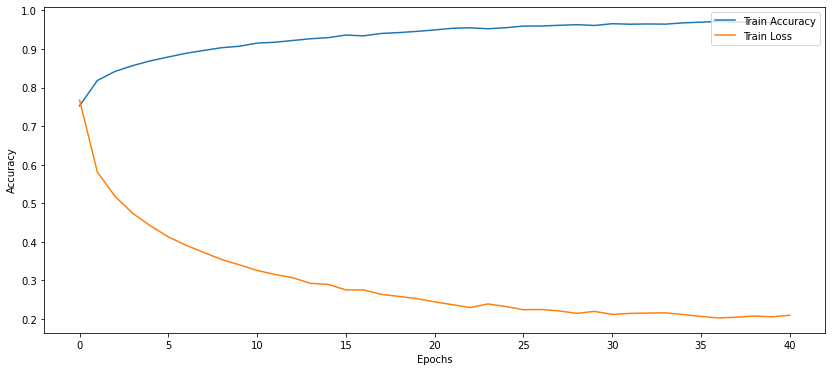

In [41]:
plt.figure(figsize=(14, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

In [24]:
datalist1 = ["./test_mfcc/강은기/강은기_3.npy", "./test_mfcc/강은서/강은서_3.npy", "./test_mfcc/김나리/김나리_3.npy",
             "./test_mfcc/김엄지/김엄지_3.npy", "./test_mfcc/김용준/김용준_7.npy", "./test_mfcc/윤동준/윤동준_3.npy",
            "./test_mfcc/이성민/이성민_0.npy", "./test_mfcc/이재빈/이재빈_3.npy", "./test_mfcc/정승화/정승화_3.npy",
            "./test_mfcc/주다빈/주다빈_3.npy", "./test_mfcc/주홍식/주홍식_3.npy"]

In [25]:
## 사용자 화자인식 테스트

num = 0
for i in datalist1 :

    XX_test = np.load(i)
    YY_test = []

    label = [0 for i in range(tf_classes)] # class의 개수만큼 y_test만드는 과정
    label[num] = 1

    for i in range(len(XX_test)) :
        YY_test.append(label)

    XX_train = np.array(X_train)
    XX_test = np.array(XX_test)
    YY_train = np.array(Y_train)
    YY_test = np.array(YY_test)
    print(num)
    XX_test = np.expand_dims(XX_test, -1)

    model.evaluate(XX_test, YY_test)
    num += 1

0
8/8 [==============================] - 0s 3ms/step - loss: 0.2045 - accuracy: 0.9651
1
5/5 [==============================] - 0s 4ms/step - loss: 0.2144 - accuracy: 0.9737
2
7/7 [==============================] - 0s 3ms/step - loss: 0.2377 - accuracy: 0.9509
3
5/5 [==============================] - 0s 2ms/step - loss: 0.1226 - accuracy: 1.0000
4
10/10 [==============================] - 0s 2ms/step - loss: 0.8474 - accuracy: 0.8875
5
4/4 [==============================] - 0s 2ms/step - loss: 0.2873 - accuracy: 0.9453
6
6/6 [==============================] - 0s 4ms/step - loss: 1.9347 - accuracy: 0.6307
7
6/6 [==============================] - 0s 2ms/step - loss: 0.1736 - accuracy: 0.9887
8
6/6 [==============================] - 0s 5ms/step - loss: 0.2566 - accuracy: 0.9598
9
3/3 [==============================] - 0s 7ms/step - loss: 0.1311 - accuracy: 1.0000
10
6/6 [==============================] - 0s 2ms/step - loss: 0.3984 - accuracy: 0.9419


In [23]:
model = load_model("./모델/model.h5")

In [44]:
model.save("./모델/model.h5")